# MAST-ML Hyperparameter Optimization Activity


---
This activity serves as a way to learn more about hyperparameter optimization. This notebook builds of of the notebook used in the "MASTML Workflows" activity so the first half or so is the same as we setup the dataset.

During the activity we'll be working with the MLPregressor model from scikit-learn. It may be useful to have the documentation for that model open as a reference as it will inform our decision making along the way.

The overall goal is to explore how we might go from the default MLPregressor provided by scikit-learn to a model that we think is performing the best for our data.

**Note: all sections before section 5 are the same as the "workflow activity" so if you've worked through that recently feel free to execute those and skip over the details if you already know what's going on. Notice how with this setup to using mastml we can copy paste previous notebooks to build off of previous ideas and explore new concepts.**

## Section 1: Setting up our Google Colab Environment
---
Before running any code we first need to install MAST-ML as well as it's dependencies into the colab environment.


In [1]:
#!pip install mastml

Now we'll sync Colab with our google drive so that we can save directly our outputs to google drive. If you haven't already I recommend making a folder in google drive titled "MASTML_colab" or something similar to direct all your results towards. Going forward I'll assume this folder exists and I'll base the runs out of that folder. If you want to change the naming that can work as well as long as you update when that location is referenced.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Here we import the MAST-ML modules used. Note that if you're making edits you may have to come back to update these imports to grab new functionality that isn't included here.

In [3]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.data_cleaning import DataCleaning
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.hyper_opt import GridSearch

Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"



And finally we'll import pandas to help with handling dataframes throughout the notebook.

In [4]:
import pandas as pd

## Section 2: Data Cleaning


---
this section is largely the same as the previous notebook in functionality.
We'll read in the same initial bandgap data we used in the previous notebook then perform the same cleaning steps:  
1) Filtering for "Reliability"  
2) Averaging bandgap values where we have duplicates  


Read in the band gap data from our dataset. If you haven't already upload the bandgap_data_v2.csv data to the MASTML_colab folder

In [5]:
mastml_df = pd.read_csv("./MASTML_colab/bandgap_data_v2.csv")

Filter for only Reliability 1

In [6]:
mastml_df_filtered = mastml_df[mastml_df["Reliability"]==1]

Note that for these steps we're not using MASTML because these are very custom steps to this dataset that aren't generic data cleaning steps included in MASTML.

We then do the same bandgap averaging when we have duplicates in the dataset.

In [7]:
mastml_df_clean = mastml_df_filtered.groupby("chemicalFormula Clean", as_index = False).mean(numeric_only=True)

This section is new. We reset the index to match the previous notebook so that we can explicitly define the same Train / Test split that we used before. The test_indices object is just a hard copied list of the index values from the previous notebook. If you want to go check them you can find the X_test object and call X_test.index to see these yourself.

In [8]:
mastml_df_clean.reset_index(inplace=True)
mastml_df_clean.drop(columns='level_0',inplace=True)

In [9]:
test_indices = [279, 168, 192,  33, 223,  22, 341, 453, 460, 455, 120, 430, 436,
            366, 292, 278, 163, 216, 420, 210, 214, 422, 340,  41, 416, 146,
            280, 229, 300, 111, 407, 250, 379,  20, 356,   4, 141, 139, 121,
            324, 147, 415,  57, 301, 393, 454,  30]

Finally we define a new column "testdata" which is going to be a binary column that is either 0 for "not testing data" or 1 for "is testing data". This is what we can feed into MAST-ML to explicitly define a set of Test data that is held out from all training.

In [10]:
mastml_df_clean["testdata"]=0

In [11]:
for idx in test_indices:
  mastml_df_clean.at[idx,'testdata']=1

In [12]:
output_path = "./MASTML_colab/bandgap_data_v3.csv"
mastml_df_clean.to_csv(output_path,index=False)

Notice how in the initial data cleaning and configuration there is still a bit that we do outside of MAST-ML. While MAST-ML gives a good deal of flexibility and useful tools for performing these machine learning workflows there will often still be custom steps like this that get added to the overall workflow that varies dataset by dataset.

## Section 3: Initializing MAST-ML
---
Now we'll dive into interacting more directly with the MAST-ML software. The first thing we need to do is setup some of the baseline information that MASTML will use as we call different sections of the code. This is similar to the [general] section from the previous configuration file oriented code base.


Set the name of the savepath to save MAST-ML results to. It's recommended to make this a unique name each time you come back to this notebook. That way all the outputs you get from each session will be in a unique location that's easier to come back to later.

By default I've set the output to the "hyperopt" folder under our colab folder.

In [13]:
SAVEPATH = './MASTML_colab/hyperopt'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

With MAST-ML initialized you should see your output directory created. You can check this using the file tree on the left of the screen or directly through google drive.

Next up we need to define the configuration of our Data file that we setup earlier. We'll define the names for all of the key components:  
target: the target variable that we want to predict  
extra_columns: the metadata columns that aren't features but we still want to keep track off  
testdata_columns: the column with binary values defining what is and isn't test data  
group_column: column names specifying unique groups in the data. We don't use this during this workflow  
as_frame: determines the structure of outputs. True gives up dataframe outputs that are easier to read in the notebook

In [14]:
target = 'Band gap values Clean'
extra_columns = ['index', 'Reliability','chemicalFormula Clean']
testdata_columns = ['testdata']

# calling the LocalDatasets section of the code initializes this section which we then execute with the method below
d = LocalDatasets(file_path='./MASTML_colab/bandgap_data_v3.csv',
                  target=target,
                  extra_columns=extra_columns,
                  group_column=None,
                  testdata_columns=testdata_columns,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

Let's take a second to look through what just happened. In the previous cell the "data_dict" object was defined. It is a dictionary of various things that were loaded in from the dataseet. We'll pull those out of the dictionary to set them all to unique objects.

We see there are 5 keys:  
  X: the X feature matrix (used to fit the ML model). notice this is empty becausee we haven't done any feature generation  
  y: the y target data vector (true values)  
  X_extra: matrix of meta data not used in fitting (i.e. not part of X or y)  
  groups: vector of group labels. empty because we didn't set it  
  X_testdata: matrix or vector of left out data indices

In [15]:
data_dict.keys()

dict_keys(['X', 'y', 'groups', 'X_extra', 'X_testdata'])

In [16]:
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

In [17]:
X.head(5)

""
0
1
2
3
4


In [18]:
groups

In [19]:
X_extra.head(5)

,index,Reliability,chemicalFormula Clean
0,808.5,1.0,Ag1Br1
1,793.5,1.0,Ag1Cl1
2,783.0,1.0,Ag1N3
3,820.0,1.0,Ag1Te1
4,785.0,1.0,Ag2O1


In [21]:
X_testdata[:]

[array([  4,  20,  22,  30,  33,  41,  57, 111, 120, 121, 139, 141, 146,
        147, 163, 168, 192, 210, 214, 216, 223, 229, 250, 278, 279, 280,
        292, 300, 301, 324, 340, 341, 356, 366, 379, 393, 407, 415, 416,
        420, 422, 430, 436, 453, 454, 455, 460], dtype=int64)]

## Section 4: Feature Generation/Engineering
---
Now we'll setup the input features for the model with a few mastml runs


If the data contains missing values (this one doesn't), we can clean the data with the built in tools in MAST-ML, which corrects missing values and provides some basic analysis of the input data. Since there are no missing values the data cleaner will still output some useful plots and statistics of our input data.

In [22]:
cleaner = DataCleaning()
X, y = cleaner.evaluate(X=X,
                        y=y,
                        method='remove',
                        axis=0,
                        savepath=savepath)

Looking at the format of the DataCleaning section also highlights the key way we will interact with MAST-ML in this format. For each section of the code we want to use we'll initialize it using what's called a class name, in this case "DataCleaning", and then call the "evaluate" method to essentially run the code for that Class.

Let's look through the outputs and compare them to some of the initial dataset analysis and compare to the previous Nanohub workflow. Open the "histogram_target_values.png" file in the newly created DataCleaning folder under our output directory. Compare back to the histogram we made in the previous notebook. Are they the same?

This is the type of check we would do to make sure we aren't missing any data switching between the two platforms.

In [25]:
y[:5]

0    3.485
1    4.190
2    3.900
3    0.850
4    1.200
Name: Band gap values Clean, dtype: float64

Next is generating the elemental features used in the model. Just like the previous step we define the class of feature generation we want to use, and then call the evaluate method. Again results are output to a new folder with the name of the Class that was evaluated. The features are also added to the X object so we can continue to use them directly without having to read in from the generated files.

You can see from the output that MAST-ML is also performing some basic feature engineering by dropping features that are missing values. This is the most basic way of handling missing values, and if we wanted to do something more complex later we could come back and use imputation to fill in those missing values instead.

In [26]:
generator = ElementalFeatureGenerator(composition_df = X_extra["chemicalFormula Clean"],
                      feature_types='composition_avg',
                      remove_constant_columns=True)
X, y = generator.evaluate(X = X,
                          y = y,
                          savepath = savepath)

Dropping 1/88 generated columns due to missing values


Using the cell block below with outputs the feature object directly compare the features generated to those in the previous workflow. Do we have the same total number?

If they're different can you think of any reasons why?  
hint: mastml does some initial cleaning automatically on the features.

In [27]:
X.head(5)

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,41.0,1.292,29.801737,93.886100,6.899312,-1.859305,3.029987,0.0,20.880000,-2.025000,...,21.645000,15.0,144.50,0.230500,214.561000,9.450,35.415000,0.680000,2.1750,4.50
1,32.0,1.217,9167.291343,71.660600,6.638434,-1.837262,3.132737,0.0,18.370000,-2.043750,...,22.650000,15.0,144.50,0.357500,214.504450,9.450,37.220500,0.680000,2.1750,4.50
2,17.0,1.051,13948.643137,37.472075,5.205755,-3.722883,5.719423,0.0,9.285000,-5.874062,...,27.573250,7.5,201.75,0.840250,107.269485,184.725,44.293500,1.577500,6.2325,4.25
3,49.5,1.522,25.516168,117.734100,7.027453,-2.777049,6.005337,0.0,22.250000,-3.296667,...,20.045000,23.0,188.50,0.218500,215.675000,18.850,31.395000,0.680000,2.1750,4.00
4,34.0,1.206,6208.782821,77.245267,5.882258,-2.633237,3.726351,0.0,13.243333,-0.678333,...,26.032333,20.0,154.00,0.463333,286.089133,272.600,41.531333,0.906667,2.9000,2.00


Next we'll see one of the benefits of using MAST-ML in this new way. Currently we don't have the same method impelemented in MAST-ML to remove highly correlated features. Previously adding this in would have been a good deal of work. But because we're using MAST-ML in this interactive notebook environment we can add in our own feature engineering steps that aren't included in the MAST-ML software. Below I just copied over the code from the previous notebook to filter highly correlated features

In [29]:
import numpy as np

In [30]:
features_corr_df = X.corr(method="pearson").abs()
# Filter the features with correlation coefficients above 0.95
upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=to_drop)

In [31]:
X.head(5)

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,BoilingT_composition_average,...,NsValence_composition_average,Polarizability_composition_average,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,valence_composition_average
0,41.0,1.292,29.801737,6.899312,-1.859305,3.029987,0.0,20.880000,-2.025000,1383.500000,...,1.500000,5.020000,21.645000,15.0,144.50,214.561000,9.450,35.415000,0.680000,4.50
1,32.0,1.217,9167.291343,6.638434,-1.837262,3.132737,0.0,18.370000,-2.043750,1336.980000,...,1.500000,4.585000,22.650000,15.0,144.50,214.504450,9.450,37.220500,0.680000,4.50
2,17.0,1.051,13948.643137,5.205755,-3.722883,5.719423,0.0,9.285000,-5.874062,666.657500,...,1.750000,2.572500,27.573250,7.5,201.75,107.269485,184.725,44.293500,1.577500,4.25
3,49.5,1.522,25.516168,7.027453,-2.777049,6.005337,0.0,22.250000,-3.296667,1848.000000,...,1.500000,6.245000,20.045000,23.0,188.50,215.675000,18.850,31.395000,0.680000,4.00
4,34.0,1.206,6208.782821,5.882258,-2.633237,3.726351,0.0,13.243333,-0.678333,1653.366667,...,1.333333,4.927333,26.032333,20.0,154.00,286.089133,272.600,41.531333,0.906667,2.00


Next up we perform the last feature engineering step, which was to normalize the features using scikit-learn's MinMaxScaler method.

In [32]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
X = preprocessor.evaluate(X=X,
                          y=y,
                          savepath=savepath)

## Section 5: Neural Network Optimization
---
In this section we'll start to analyze the NN from scikit-learn the MLPRegressor which stands for Multi-layer Perceptron Regressor. We can find the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

We'll use the same assessment techniques as before where we use a combination of 5-Fold cross validation and the previously established test set to measure model predictive ability.

During this activity we'll go through a number of different steps to optimize our neural network. For our first step let's use the grid search method outlined previously to grid over a number of different hyperparameters.

Because the neural network model tends to take a bit longer to train we'll do a very rough grid of each hyperparameter so that we can run through quickly and identify what sorts of values are working best for each hyperparameter. After this initial run we can then narrow down either the range of values to get a more fine gride. Or we could start to exclude hyperparameters if we think we've found the best value for them overall.

We'll initially set up a rough grid over 3 hyperparameters:

1) Alpha (Regularization)  
  Let's set a minimum value of 10^-8, a max of 10^2, with 5 grid points. Since we're varying over orders of magnitude it's easier to do this in log space, and our alpha values should be floats. so the string to setup this grid should look like 'x y z log float' with x and y being the exponents for the numbers and z being the number of grid points.  
2) Initial learning rate  
  For the learning rate we'll do the same thing but set the minimum to 10^-5 and max 10^1 with 5 grid points again.  
3) Activation  
  Activation is a categorical hyperparameter so it gets handled a bit differently. Looking at the sklearn documentation the available activation functions are: identity, logistic, tanh, and relu. We can include all of them, seperated by spaces. And at the end we include the "str" to let mastml know this is a list os strings to use for this hyperparameter. so for the value input set it as 'identity logistic tanh relu str' to have it try all the activation function options  

  To include multiple hyperparameters in the grid search we seperate them by a semicolon   
  So the code below should look like this:

  hyperparams = 'alpha ; learning_rate_init ; activation'  
  param_vals = '-8 2 5 log float ; -5 1 5 log float ; identity logistic tanh relu str'


In [33]:
default_model = SklearnModel(model='MLPRegressor')
models = [default_model]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

### here's the key grid search settings we're going to edit
# hyperparams = 'param1; param2; param3'
# param_vals = '1 5 3 log float; 2 10 5 log float; activation1 activation2 activation3 activation4 activation5'
hyperparams = 'alpha ; learning_rate_init ; activation'
param_vals = '-8 2 5 log float ; -5 1 5 log float ; identity logistic tanh relu str'
###

grid1 = GridSearch(param_names=hyperparams,param_values=param_vals,scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit() # note: even though we're using nosplit here by manually specifying the "leaveout_inds" option below we are manually defining a test set to leave out, so we still have test data.
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

With this initial rough grid search complete let's go look through our results. Locate the "gridsearch_mlpregressor_output.xlsx" file in the split_outer_0/split_0 folder and open it up to view how the model performed under each combination of hyperparameters. Because we varied so many at a time we can't make a simple one-dimensional learning curve.

For this initial rough grid search what we're trying to identify is roughly what hyperparameter values are performing better so we can refine our search. for now let's just sort the values by the mean test score column so we can see what performed best. You can do this by opening the output in excel, or optionally you could read that output file back into the notebook here to do your analysis.


Here's what the file should look like. On the left is a list of the hyperparameters and their values, the mean_test_score column is the RMSE (in this case the negative of the RMSE for compuational reasons), and the std_test_score is the standard deviation of the values from the multipl CV tests performed.

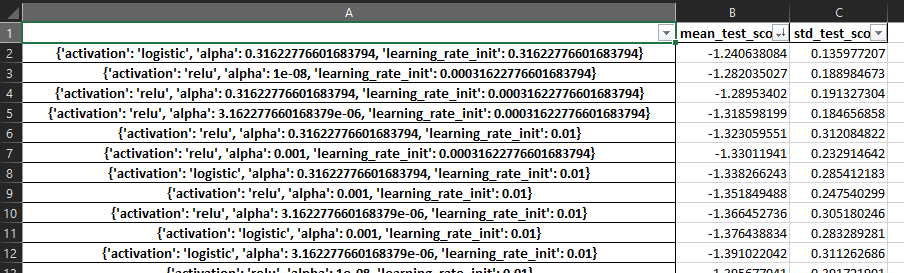


For the top 10 or so performing combinations of hyperparameters let's ask ourselves a few questions:  
1) For each hyperparameter is there a common range for the numerical ones or common category for the categorical ones that is clearly dominating? For example we might notice that a certain activation function is consistently performing well. Or that all of the learning rate values are around 10^-3. Take note of this for each hyperparameter, or if there isn't a clear trend note that as well.

2) How quickly is performance dropping off during this rough grid search. For example find the performance for the top perfoming combination (for me it was {'activation': 'logistic', 'alpha': 0.31622776601683794, 'learning_rate_init': 0.31622776601683794}) and for each numerical hyperparameter find the decrease in performance as each hyperparameter moves up and down one grid step.

3) Finally for the numerical hyperparameters do any of them continuously decrease towards the boundary that we gave them? this might indicate we needed to do a wider grid search initially. Otherwise if we're finding minimum values within the previous range that means we can start to narrow the search.

Using the information from this previous analysis we'll establish our next search. Based on a quick look through the results I found the following:
- for learning rate it looks like 10^-1 to 10^-5 are performing best so let's move the outer bounds of the grid in to match those new values  
- for regularization values from 10^0 to 10^-8 were giving decent results so let's move those bounds in a bit on the high side  
- for the activation function all values are represented in the well performing models except the identity function (which makes sense). So we could make a few choices here. In the interest of time let's just pick the one that is most populated in the top 10 and use that going forward. Make sure to keep track of which one that is! For me it was the logistic function.

Using these notes update your grid search from above and copy into the cell below to make your adjustments. To exclude the activation function from the grid search make sure to remove those sections. and add the extra input:  
activation='logistic'  
to the initial definition of the default_model object

Also because we've removed one of the hyperparameters from the grid lets increase the grid density to 10.

**Note: this will take a bit to run**

In [34]:
default_model = SklearnModel(model='MLPRegressor',activation="logistic")
models = [default_model]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

### here's the key grid search settings we're going to edit
# hyperparams = copy_and_edit_from_the_previous_cell
# param_vals = copy_and_edit_from_the_previous_cell

hyperparams = 'alpha ; learning_rate_init'
param_vals = '-8 0 10 log float ; -5 -1 10 log float'
###

grid1 = GridSearch(param_names=hyperparams,param_values=param_vals,scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit() # note: even though we're using nosplit here by manually specifying the "leaveout_inds" option below we are manually defining a test set to leave out, so we still have test data.
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

Conducting a similar analysis of the results as we did previously we'll refine the grid search one more time. Because we now have just two hyperparameters and both are numerical we could also make a heatmap of performance across the grid to identify which areas are performing well. For now, in the interest of time we'll skip making the full heatmap and again just do a quick scan of the top performing combinations of hyperparameters.

For the learning rate hyperparameter it looks like performance drops consistently when the value goes below 10^-3, while the regularization doesn't have a clear trend. Instead many of the top combinations vary over many orders of magnitude. This suggests that the model isn't very sensitive to this parameter within the range we've given it so similar to before let's just pick and value to fix and only vary the learning rate. So let's set the regularizatin to:  
alpha=0.001

Again because we've narrowed down the hyperparameters we can increaes the grid density of the remaining parameter. Lets set the number of grid points to 50 to do a much finer grid. Again copy the above settings to the cell below and make your adjustments.

In [35]:
default_model = SklearnModel(model='MLPRegressor',activation='logistic',alpha=0.001)
models = [default_model]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

### here's the key grid search settings we're going to edit
hyperparams = 'learning_rate_init'
param_vals = '-5 -1 50 log float'
###

grid1 = GridSearch(param_names=hyperparams,param_values=param_vals,scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

With this grid search what was the best learning rate?

With this grid search complete we can say we've fairly thoroughly investigated various combinations of hyperparameters and found the best combination. However, one thing we haven't done yet it varied the neuron structure of the network. There is a hyperparameter which sets this, called "hidden_layer_sizes" which is structured as a tuple of numbers where each number is the number of neurons in that hidden layer. For a few examples:

hidden_layer_sizes = (100,)   
The default setting, 100 neurons in a single hidden layer  
hidden_layer_sizes = (100,100)  
2 layers, each with 100 neurons  
hidden_layer_sizes = (100,50,20)  
3 layers, each reducing the number of neurons  


by default Scikit-learn sets the network to have one layer with 100 neurons. As a last optimization step let's try to vary this structure and see how it affects the results.

For simplicity we'll fix the other hyperparameters to the values obtained from the previous grid search (in reality it would be more complete to repeat the process for each neuron structure). And we'll try a few different neuron configurations.

1) Reduce the number of neurons in the single layer to 50. How does this affect the results? Does the simpler model cause a drop in performance?

2) If it doesn't, keep decreasing by 10 until you see a significant change in performance. Note: for me this occurred around 20 neurons.

3) Let's try multiple layers. Using the previous result of 20 neurons lets increase the number of layers to 2 and then 3 and see how the performance is affected. Did increasing the number of layers affect performance? (also note: this isn't a fully complete way to optimize this structure overall, we're just trying a few different combinations).

4) based on these results try to find the best structure with the previouosly set hyperparameters. You might try adding layers that increase or reduce in size like the examples above. Report the best model you find!

Note: for the first three questions the cell below is setup to do a grid of all of these options. For question 4 you might want to remove the ones that performed poorly to increase the speed of running


In [37]:
default_model = SklearnModel(model='MLPRegressor',activation='logistic',alpha=0.001,learning_rate_init=0.001)
models = [default_model]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

### here's the key grid search settings we're going to edit
hyperparams = 'hidden_layer_sizes'
param_vals = '(100,) (50,10) (40,) (30,) (20,) (10,) (20,20) (20,20,20) tup'
###

grid1 = GridSearch(param_names=hyperparams,param_values=param_vals,scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

What we've introduced here is one way to approach hyperparameter optimization through an iterative search of defined grids of parameters. Other methods that are built into mastml, which we haven't explored here are:
- Bayesian Search, a guided search using bayesian statistics
- Randomized Search, random combinations meant to help avoid getting trapped in local minima

And other methods that we could use which aren't currently in MASTML:
- genetic algorithm search
- NN search, using another NN as the model for proposing new hyperparameter combinations to try.

if you are interested in trying out some of the other options built into mast-ml please check out the documentation and further tutorials here: https://mastmldocs.readthedocs.io/en/latest/0_5_tutorials.html